<a href="https://colab.research.google.com/github/takaito1/EAS4821_S2024/blob/main/Week11_exercise_CO2_box_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### read atmospheric CO2 concentration from Mauna Loa

In [30]:
# read CO2 concentration data
df=pd.read_csv('/content/drive/MyDrive/co2_mlo.tsv',delimiter='\t',header=None)
data=df.to_numpy()
time=data[:,2].astype(float)
co2=data[:,3].astype(float)
co2[co2<0]=np.nan
ind=(time>=1990)&(~np.isnan(co2))

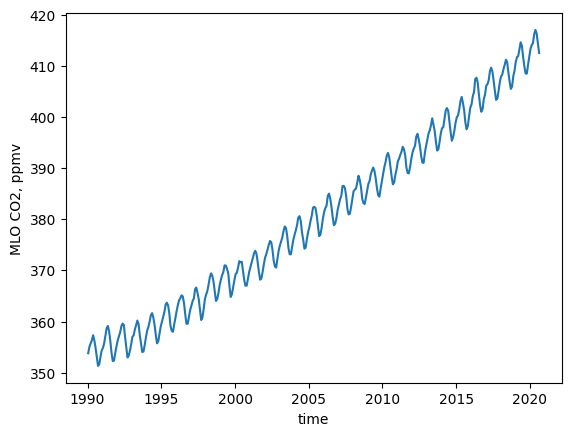

In [31]:
# let's plot data from 1990
ind=(time>=1990)&(~np.isnan(co2))
plt.figure()
plt.plot(time[ind],co2[ind],label='observed')
plt.xlabel('time')
plt.ylabel('MLO CO2, ppmv')

fn='Fig_MLO_CO2'
# plt.savefig(fn+'.pdf',bbox_inches="tight",dpi=300)
# plt.savefig(fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

### Part I: Estimate parameters using MLR, plot the analytic solution

In [32]:
# estimate parameters using MLR
t0=1990
x=time[ind]-t0
y=co2[ind]
N=np.size(x)

# assemble the matrix
A=np.ones((N,3)) # N x 3 matrix
A[:,1]=np.sin(2*np.pi*x) # sin(2*pi*t) term
A[:,2]=x # t-t0 term

# perform MLR using pseudo inverse
xvec=np.linalg.pinv(A)@y

# estimate y using fitted paramters
yest=A@xvec

xvec

array([349.74522185,   2.86743701,   2.00520365])

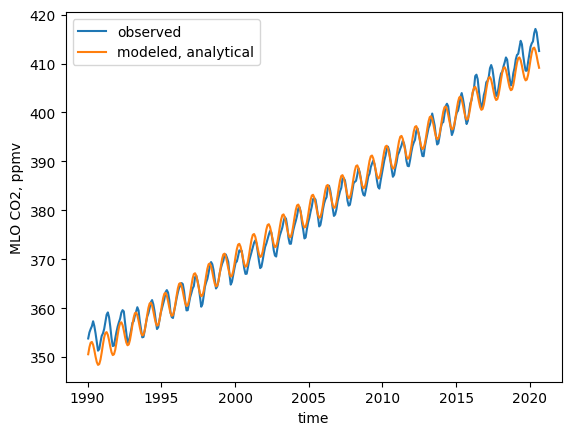

In [33]:
# compare modeled vs. obs.
plt.figure()
plt.plot(time[ind],y,label='observed')
plt.plot(time[ind],yest,label='modeled, analytical')
plt.xlabel('time')
plt.ylabel('MLO CO2, ppmv')
plt.legend()
fn='Fig_MLO_CO2_MLR_analytical'
plt.savefig(fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig(fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

### Part II: numerical solution

In [34]:
# define the function for dX/dt
def fun_ODE(t,X, B, F, O):
    dX_dt=B*np.cos(2*np.pi*t)+F-O
    return dX_dt

In [35]:
# Numerical solution with Euler forward method
# setup model parameters
dt=0.01 # time step 0.01 year
B=2.837*2*np.pi # respiration and photosynthesis cycles, ppmv/year
F=4.049 # fossil fuel emissions, ppmv/year
O=2 # ocean uptake, ppmv/year

X0=349.432 # initial CO2 concentration at t0
t0=1990 # start time
t1=2023 # end time

# generate time vector
T=np.arange(t0,t1,dt)

# number of time steps
N=np.size(T)

X=0*T # initialize X values with zeros

X[0]=X0 # initial value of X

# forward Euler method
for ii in np.arange(1,N, 1):
    # ii is for the time step n+1
    t=T[ii]-t0 # time of current step
    # X value in the previous time step
    Xn=X[ii-1]
    dX_dt=fun_ODE(t,Xn, B, F, O)
    X[ii]=Xn+dX_dt*dt

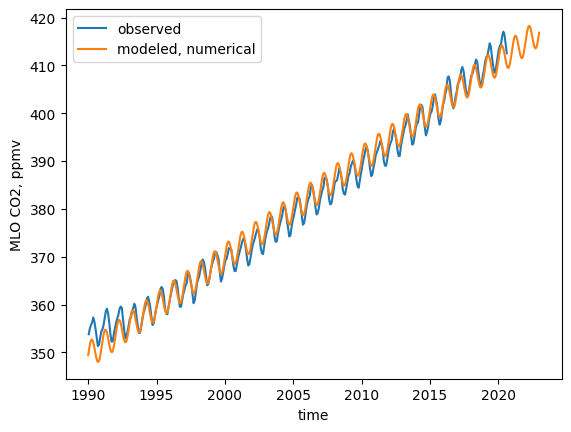

In [36]:
# visualize the results
plt.figure()
plt.plot(time[ind],co2[ind],label='observed')
plt.plot(T,X,label='modeled, numerical')
plt.xlabel('time')
plt.ylabel('MLO CO2, ppmv')
plt.legend()
fn='Fig_MLO_CO2_MLR_numerical'
plt.savefig(fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig(fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

### Part III: Improve the model with actual CO2 emission

In [37]:
# improve the model with time-varied CO2 emissions
# https://ourworldindata.org/co2-emissions#global-co2-emissions

df_emis=pd.read_csv('/content/drive/MyDrive/CO2_Emissions.txt',delimiter='\t',skiprows=1)
data_emis=df_emis.to_numpy()
Year_emis=data_emis[:,0]
# unit: billion tonnes (10^12 kg)
CO2_emis=data_emis[:,1]
CO2_emis

array([22.7 , 23.17, 22.44, 22.68, 22.84, 23.33, 24.05, 24.19, 24.11,
       24.43, 25.12, 25.33, 25.91, 27.18, 28.47, 29.41, 30.37, 31.29,
       31.95, 31.46, 33.13, 34.21, 34.76, 34.99, 35.24, 35.21, 35.22,
       35.7 , 36.42, 36.44, 34.07])

In [38]:
# convert emission from tonne/year to ppmv per year
m_air=5.148e18 # total mass of atmosphere, kg
CO2_emis_ppm=CO2_emis*1e12/m_air*(29/44)*1e6 # convert the unit: ppm/year
CO2_emis_ppm

array([2.90624779, 2.96642121, 2.87296037, 2.90368722, 2.92417179,
       2.98690577, 3.07908632, 3.09701031, 3.08676803, 3.12773716,
       3.21607685, 3.24296285, 3.3172194 , 3.47981564, 3.64497245,
       3.76531928, 3.88822667, 4.00601293, 4.09051176, 4.02777778,
       4.24158543, 4.37985625, 4.45027195, 4.47971851, 4.51172565,
       4.50788479, 4.50916508, 4.57061878, 4.66279932, 4.66535989,
       4.36193226])

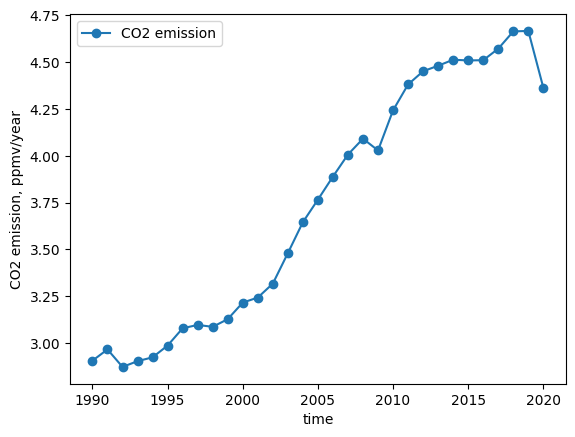

In [39]:
plt.figure()
plt.plot(Year_emis,CO2_emis_ppm,'o-',label='CO2 emission')
plt.xlabel('time')
plt.ylabel('CO2 emission, ppmv/year')
plt.legend()
fn='Fig_CO2_emis'
plt.savefig(fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig(fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

In [40]:
# construct an interpolation for CO2 emission
f_interp = interpolate.interp1d(Year_emis, CO2_emis_ppm, bounds_error=False)

In [41]:
# Numerical solution
# setup model parameters
dt=0.01 # time step 0.01 year
# B=3*2*np.pi # respiration and photosynthesis cycles, ppmv/year
B=21
# we will dynamically update F and O values in the loop
# F=4 # fossil fuel emissions, ppmv/year
# O=2 # ocean uptake, ppmv/year

co2_sel=co2[ind]

X0=co2_sel[0] # initial CO2 concentration at t0
t0=1990 # start time
t1=2022 # end time

# generate time vector
T=np.arange(t0,t1,dt)

# number of time steps
N=np.size(T)

X=0*T # initialize X values with zeros

X[0]=X0 # initial value of X

# Euler forward method
for ii in np.arange(1,N, 1):
    # ii is for the time step n+1
    t=T[ii]-t0 # time of current step
    F=f_interp(T[ii]) # dynamically update emission of CO2
    O=0.475*F
#     O=0.475*F # fraction of CO2 emission absorbed by the ocean
    # X value in the previous time step
    Xn=X[ii-1]
    dX_dt=fun_ODE(t,Xn, B, F, O)
    X[ii]=Xn+dX_dt*dt

In [42]:
X0

353.8

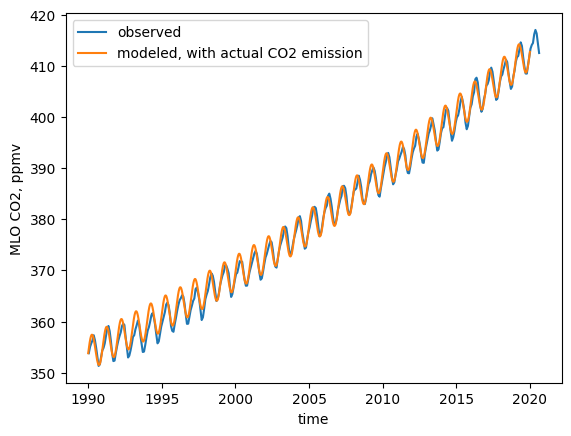

In [43]:
# visualize the results
plt.figure()
plt.plot(time[ind],co2[ind],label='observed')
plt.plot(T,X,label='modeled, with actual CO2 emission')
plt.xlabel('time')
plt.ylabel('MLO CO2, ppmv')
plt.legend()
fn='Fig_MLO_CO2_MLR_numerical_wCO2emis'
plt.savefig(fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig(fn+'.png',bbox_inches="tight",dpi=300)
plt.show()